# Iris classification

This notebook will walk through the process of using the ITEA for classification (``ITEA_classifier``) and interpreting the final expression with the ``itea.inspection`` tools.

In [1]:
import numpy  as np
import pandas as pd

# automatically differentiable implementation of numpy
import jax.numpy as jnp

from sklearn import datasets
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.classification import ITEA_classifier
from itea.inspection     import *

import warnings; warnings.filterwarnings('ignore')

We will use the Iris data set in this example.

This data set contains 3 different classes of Iris flowers and has 4 features: sepal width, sepal length, petal width, and petal length.

One example of each flower is illustrated in the figure below.

![](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png)

## Creating and fitting an ``ITEA_classifier``

In [2]:
iris_data = datasets.load_iris()
X, y      = iris_data['data'], iris_data['target']
labels    = iris_data['feature_names']
targets   = iris_data['target_names']

# changing numbers to the class names
y_targets = [targets[yi] for yi in y]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_targets, test_size=0.33, random_state=42)

# Creating transformation functions for ITEA using jax.numpy
# (so we don't need to analytically calculate its derivatives)
tfuncs = {
    'id'       : lambda x: x,
    'sqrt.abs' : lambda x: jnp.sqrt(jnp.abs(x)), 
    'log'      : jnp.log,
    'exp'      : jnp.exp
}

clf = ITEA_classifier(
    gens            = 50,
    popsize         = 50,
    max_terms       = 3,
    expolim         = (-2, 2),
    verbose         = 5,
    tfuncs          = tfuncs,
    labels          = labels,
    simplify_method = 'simplify_by_var',
    random_state    = 42,
).fit(X_train, y_train)

gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.34 	 0.8178 	 0.98 	 0min27seg
5 	 0.93 	 0.9518000000000001 	 0.97 	 0min28seg
10 	 0.73 	 0.9618000000000001 	 0.98 	 0min22seg
15 	 0.96 	 0.9793999999999999 	 0.98 	 0min22seg
20 	 0.95 	 0.9779999999999999 	 0.99 	 0min19seg
25 	 0.97 	 0.9808 	 0.99 	 0min17seg
30 	 0.96 	 0.9818000000000001 	 0.99 	 0min16seg
35 	 0.96 	 0.9862000000000001 	 0.99 	 0min19seg
40 	 0.97 	 0.9876 	 0.99 	 0min10seg
45 	 0.94 	 0.9858000000000001 	 0.99 	 0min4seg


## Inspecting the results from ``ITEA_classifier`` and ``ITExpr_classifier``

Now that we have fitted the ITEA, our ``clf`` contains the ``bestsol_`` attribute, which is a fitted instance of ``ITExpr_classifier`` ready to be used.

In [3]:
final_itexpr = clf.bestsol_

final_itexpr.to_str(term_separator='\n')

'[-3.818 -0.111  3.929]*sqrt.abs(sepal width (cm)^-1 * petal length (cm)^2 * petal width (cm)^2)\n[ 1.061  0.669 -1.73 ]*log(sepal length (cm)^2 * sepal width (cm) * petal length (cm)^2 * petal width (cm))\n[ 1.764 -1.136 -0.627]'

In [4]:
print(classification_report(
    y_test,
    final_itexpr.predict(X_test),
    target_names=targets
))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.93      0.93      0.93        15
   virginica       0.94      0.94      0.94        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



We can use the ``ITExpr_inspector`` to obtain metrics regarding the IT terms in the expression

In [5]:
display(pd.DataFrame(
    ITExpr_inspector(
        itexpr=final_itexpr, tfuncs=tfuncs
    ).fit(X_train, y_train).terms_analysis()
))

,coef,func,strengths,coef\nstderr.,mean pairwise\ndisentanglement,mean mutual\ninformation,prediction\nvar.
0,[-3.818 -0.111 3.929],sqrt.abs,"[0, -1, 2, 2]",[2.783 0.904 1.361],0.883,1.219,[1.0118e+02 8.5000e-02 1.0713e+02]
1,[ 1.061 0.669 -1.73 ],log,"[2, 1, 2, 1]",[1.805 0.941 2.044],0.883,1.219,[ 5.798 2.303 15.41 ]
2,[ 1.764 -1.136 -0.627],intercept,---,[ 6.255 3.789 12.576],0.000,0.000,[0. 0. 0.]


By using the ``ITExpr_texifier``, we can create formatted LaTeX strings of the final expression and its derivatives.

In [6]:
# The final expression
display(Latex(
    '$ ITExpr = ' + ITExpr_texifier.to_latex(
        final_itexpr,
        term_wrapper=lambda i, term: r'\underbrace{' + term + r'}_{\text{term ' + str(i) + '}}'
    ) + '$'
))

<IPython.core.display.Latex object>

In [7]:
# List containing the partial derivatives
derivatives_latex = ITExpr_texifier.derivatives_to_latex(
    final_itexpr,
    term_wrapper=lambda i, term: r'\underbrace{' + term + r'}_{\text{term ' + str(i) + r' partial derivative}}'
)

# displaying one of its derivatives
display(Latex(
    r'$ \frac{\partial}{\partial ' + labels[0] + '} ITExpr = ' + derivatives_latex[0] + '$'
))

<IPython.core.display.Latex object>

## Explaining the ``IT_classifier`` expression using Partial Effects

Now let's create an instance of ``ITExpr_explainer``.

We can calculate feature importances with Partial Effects (PE) or approximate the Shapley values using PE.

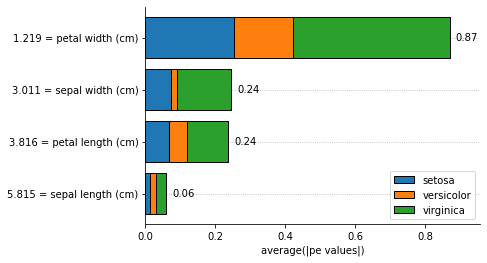

In [8]:
explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

explainer.plot_feature_importances(
    X = X_train,
    importance_method = 'pe', # change to 'shapley'
    grouping_threshold = 0.0,
    target = None,
    barh_kw = {'edgecolor' : 'k'},
    show = True
)

We can explain a single instance as well:

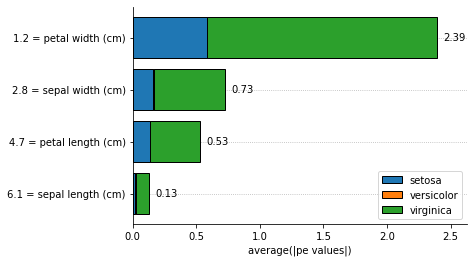

In [9]:
explainer.plot_feature_importances(
    X = X_test[0, :].reshape(1, -1),
    importance_method = 'pe', # change to 'shapley'
    grouping_threshold = 0.0,
    target = None,
    barh_kw = {'edgecolor' : 'k'},
    show = True
)

Instead of looking into the average Partial Effects, we can plot the Partial Effects for each variable when its co-variables are fixed at the means.

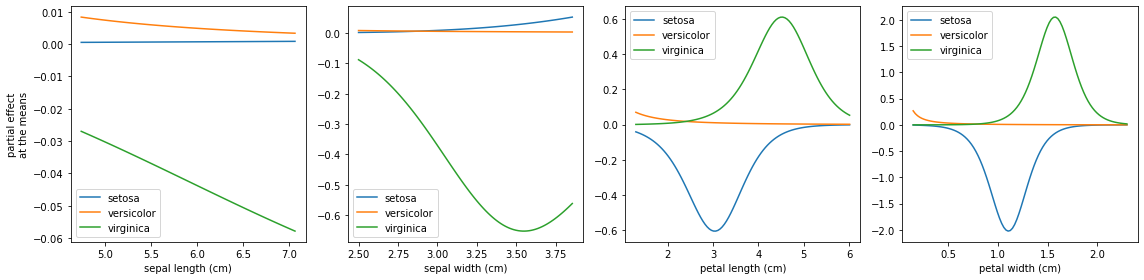

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

explainer.plot_partial_effects_at_means(
    X          = X_test, # Obtaining explanations for test data 
    ax         = axs,
    features   = final_itexpr.labels,
    target     = None,
    num_points = 100,
    share_y    = False,
    show_err   = False,
    show       = False,
)

plt.tight_layout()
plt.show()

We can share the y axis and show errors hatchs:

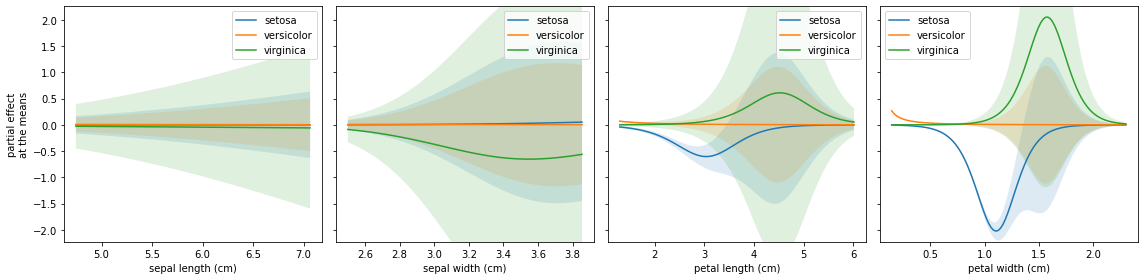

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

explainer.plot_partial_effects_at_means(
    X          = X_test, # Obtaining explanations for test data 
    ax         = axs,
    features   = final_itexpr.labels,
    target     = None,
    num_points = 100,
    share_y    = True,
    show_err   = True,
    show       = False,
)

plt.tight_layout()
plt.show()